In [1]:
import os
import re

import pandas as pd
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from data_imputation_paper.experiment import _recursive_split, read_experiment, read_csv_files

# plotting settings
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
experiment_path = Path("../data/experiments/cluster/fully_observed")

In [4]:
read_experiment(experiment_path).head()

,experiment,imputer,task,missing_type,missing_fraction,strategy,file,path
0,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_std_input4.csv,../data/experiments/cluster/fully_observed/Aut...
1,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,downstream_performance_std_input4.csv,../data/experiments/cluster/fully_observed/Aut...
2,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_mean_input4.csv,../data/experiments/cluster/fully_observed/Aut...
3,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,downstream_performance_mean_input4.csv,../data/experiments/cluster/fully_observed/Aut...
4,fully_observed,AutoKerasImputer,32,MCAR,0.3,single_all,impute_performance_mean_input8.csv,../data/experiments/cluster/fully_observed/Aut...


In [11]:
results = read_csv_files(read_experiment(experiment_path))
results.head()

,metric,train,test,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,baseline,corrupted,imputed
0,MAE,2.423165,3.564116,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
1,MSE,30.923196,32.844677,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
2,RMSE,2.642595,3.564116,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,input4,impute_performance_std,NaN,NaN,NaN
3,MAE,0.441542,1.079771,fully_observed,AutoKerasImputer,32,MCAR,0.30,single_all,input8,impute_performance_std,NaN,NaN,NaN
4,MSE,17.692893,44.049110,fully_observed,AutoKerasImputer,32,MCAR,0.30,single_all,input8,impute_performance_std,NaN,NaN,NaN


<AxesSubplot:title={'center':'Downstream Mean RMSE (imputed)'}, ylabel='Density'>

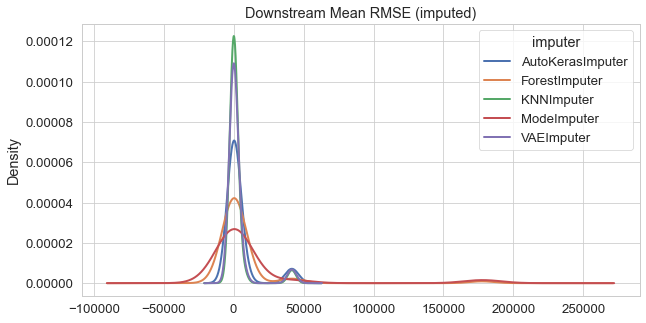

In [6]:
row_idx = (results["metric"] == "RMSE") & (results["result_type"] == "downstream_performance_mean")
cols = ["imputed", "imputer"]
data = results.loc[row_idx, cols]
data = data.pivot(columns="imputer", values="imputed")
data.plot(kind="kde", title="Downstream Mean RMSE (imputed)", figsize=(10,5))

In [7]:
results.head()

,metric,train,test,experiment,imputer,task,missing_type,missing_fraction,strategy,result_type,baseline,corrupted,imputed
0,MAE,2.423165,3.564116,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_std,NaN,NaN,NaN
1,MSE,30.923196,32.844677,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_std,NaN,NaN,NaN
2,RMSE,2.642595,3.564116,fully_observed,AutoKerasImputer,32,MCAR,0.01,single_all,impute_performance_std,NaN,NaN,NaN
3,MAE,0.441542,1.079771,fully_observed,AutoKerasImputer,32,MCAR,0.30,single_all,impute_performance_std,NaN,NaN,NaN
4,MSE,17.692893,44.049110,fully_observed,AutoKerasImputer,32,MCAR,0.30,single_all,impute_performance_std,NaN,NaN,NaN


Text(0.5, 1.0, 'Imputation RMSE with 25% Confidence Band')

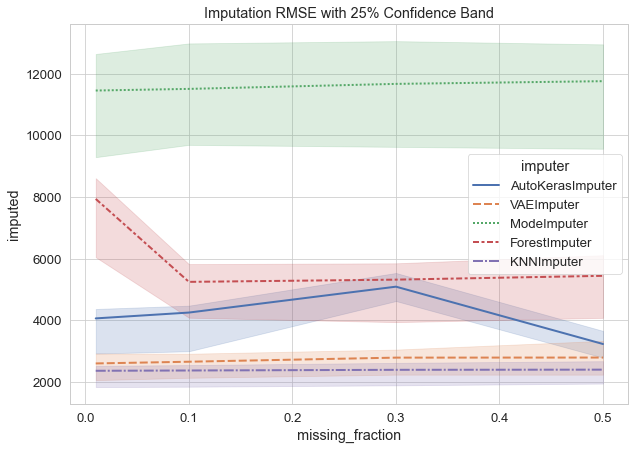

In [8]:
row_idx = (results["metric"] == "RMSE") & (results["result_type"] == "downstream_performance_mean")
cols = ["imputed", "imputer", "missing_fraction"]
data = results.loc[row_idx, cols]

plt.figure(figsize=(10,7))
ax = sns.lineplot(
    data=data, 
    x="missing_fraction", 
    y="imputed", 
    hue="imputer", 
    style="imputer", 
    ci=25
)
ax.set_title("Imputation RMSE with 25% Confidence Band")

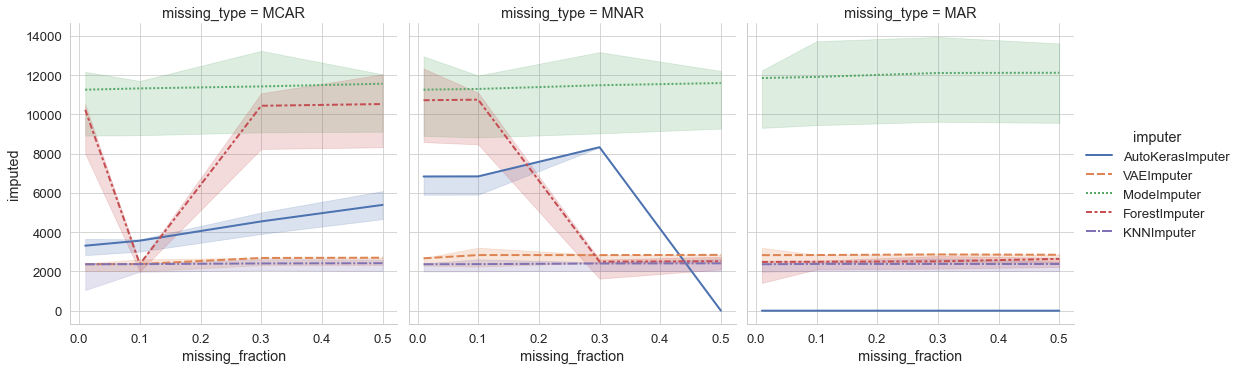

In [9]:
row_idx = (results["metric"] == "RMSE") & (results["result_type"] == "downstream_performance_mean")
data = results[row_idx]

sns.relplot(
    data=data, 
    x="missing_fraction", 
    y="imputed", 
    hue="imputer", 
    style="imputer", 
    ci=25,
    col="missing_type",
    kind="line"
)